In [1]:
pip install facenet-pytorch

     |████████████████████████████████| 1.9MB 2.8MB/s 


In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt


workers = 0 if os.name == 'nt' else 4

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
#resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)
#resnet = InceptionResnetV1(num_classes=100).eval().to(device)

In [17]:
def collate_fn(x):
  return x[0]

dataset = datasets.ImageFolder('/content/test_images/')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [18]:
mtcnn_annotated = {}
for i,x in enumerate(loader):
  #print(x[0])
  boxes, probs, landmarks = mtcnn.detect(x[0], landmarks=True)
  t = boxes
  l = landmarks
  boxes=boxes[0]
  landmarks=landmarks[0].tolist()
  list(np.float_(landmarks))

  bb = {}
  lm = {}
  bb = {"x":float(boxes[0]),"y":float(boxes[1]),"w":float(boxes[2])-float(boxes[0]),"h":float(boxes[3])-(boxes[1])}
  
  lm = {"left_eye": landmarks[0], "right_eye": landmarks[1], "nose": landmarks[2], "left_mouth": landmarks[3], "right_mouth": landmarks[4]}
  mtcnn_annotated[i] = {"bounding_box":bb,"landmarks":lm}
  


  
  fig, ax = plt.subplots(figsize=(16, 12))
  ax.imshow(x[0])
  ax.axis('off')
  boxes = t
  landmarks = l
  for box, landmark in zip(boxes, landmarks):
    #print(pts)
    print(box)
    ax.plot(box[[0, 2]],box[[1, 1]],'r-')
    ax.plot(box[[0, 2]],box[[3, 3]],'g-')
    ax.plot(box[[2, 2]],box[[1, 3]],'g-')
    ax.plot(box[[0, 0]],box[[3, 1]],'g-')

    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    pts = (np.meshgrid(box[[0, 2]], box[[1, 3]]))
    #print(pts)
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
  fig.show()




Output hidden; open in https://colab.research.google.com to view.

In [19]:
print(mtcnn_annotated)

{0: {'bounding_box': {'x': 170.14173889160156, 'y': 126.57473754882812, 'w': 336.31398010253906, 'h': 441.5251159667969}, 'landmarks': {'left_eye': [266.2254333496094, 286.10211181640625], 'right_eye': [420.248291015625, 276.8558044433594], 'nose': [349.02117919921875, 360.152099609375], 'left_mouth': [272.14263916015625, 444.69512939453125], 'right_mouth': [429.95330810546875, 440.2620849609375]}}, 1: {'bounding_box': {'x': 331.060302734375, 'y': 255.88023376464844, 'w': 482.01898193359375, 'h': 628.4544219970703}, 'landmarks': {'left_eye': [471.0080871582031, 481.39678955078125], 'right_eye': [693.4989624023438, 498.7867736816406], 'nose': [574.083984375, 595.3330078125], 'left_mouth': [448.87799072265625, 705.5185546875], 'right_mouth': [677.23193359375, 725.3114013671875]}}, 2: {'bounding_box': {'x': 132.81085205078125, 'y': 205.45468139648438, 'w': 499.515869140625, 'h': 669.6319274902344}, 'landmarks': {'left_eye': [260.4444580078125, 468.2833251953125], 'right_eye': [495.2979431

In [20]:
import json



json = json.dumps(mtcnn_annotated)
f = open("mtcnn_annotated.json","w")
f.write(json)
f.close()

170 126 336 442


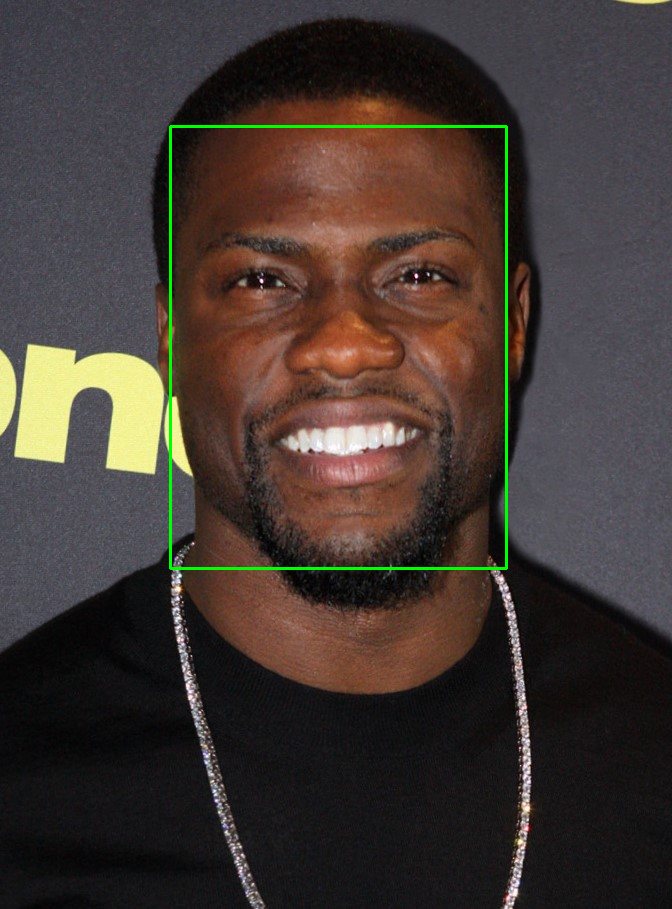

In [14]:
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread("/content/test/1/00_m_m.jpg")
id = "0"
#170 126 506 568

x = 170
y=126
w=506-170
h=568-126
print(x,y,w,h)


#landmarks = faces_annotated[id]["landmarks"]


cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
cv2_imshow(image)